# Stock Price Prediction using LSTM 
Have you ever wished you could predict the future, especially when it comes to your investments? While a crystal ball might be out of the question, there’s a powerful tool called an LSTM network that can analyze complex patterns in historical data, like stock prices. Unlike traditional methods, LSTMs have a special memory that allows them to remember important information for long stretches, making them ideal for navigating price movements in the ever-changing world of finance.

In this project section, we’ll use LSTMs and explore how a machine learning algorithm can be used to potentially predict stock prices, along with the exciting possibilities and important considerations to keep in mind.

### Step 1: Import libraries

In [ ]:
# Standard Libraries
import os
import json
import urllib.request
import logging
import datetime as dt

# Data Manipulation and Analysis Libraries
import numpy as np
import pandas as pd
from pandas_datareader import data

# Data Visualization Libraries
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# TensorFlow and Keras Libraries
import tensorflow as tf  # This code has been tested with TensorFlow 1.6
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

### Step 2: Load the Dataset and Explore

In [72]:
df = pd.read_csv('../../data/cleaned/cleaned_SPY.csv')
df = df[['Date', 'Adj Close']]
# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x.split()[0]))
df = df.set_index(df['Date']).drop('Date', axis=1)
df.head()

,Adj Close
Date,
2015-01-02,206.380005
2015-01-05,204.169998
2015-01-06,202.089996
2015-01-07,201.419998
2015-01-08,204.009995


In [73]:
df.shape

(2474, 1)

### Step 3: Splitting Data into a Training set and a Test set

In [74]:
train_size = round(len(df) * 0.8)

train_data = df[:train_size]
test_data = df[train_size:]

### Step 4: Normalizing the Data

Now we need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. We can also reshape the training and test data to be in the shape [data_size, num_features].

In [ ]:
# Scale the data to be between 0 and 1
# When scaling remember! We normalize both test and train data with respect to training data
# Because we are not supposed to have access to test data

scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

Due to the observation we made earlier, that is, different time periods of data have different value ranges, we normalize the data by splitting the full series into windows. If we don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here we choose a window size of 450.

Note: when choosing the window size make sure it's not too small, because when you perform windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this step, 4 data points will be affected by this. But given we have 1980 data points, 4 points will not cause any issue

In [ ]:
# Set the smoothing window size
smoothing_window_size = 450  # Adjust this as needed, must be <= train_size


# Normalize the training data using a sliding window approach
for di in range(0, len(train_data), smoothing_window_size):
    end_index = min(di + smoothing_window_size, len(train_data))  # Ensure we don't go out of bounds
    scaler.fit(train_data.iloc[di:end_index, :])
    train_data.iloc[di:end_index, :] = scaler.transform(train_data.iloc[di:end_index, :])

# If there's any remaining data after the last window
if end_index < len(train_data):
    scaler.fit(train_data.iloc[end_index:, :])
    train_data.iloc[end_index:, :] = scaler.transform(train_data.iloc[end_index:, :])

Reshape the data back to the shape of [data_size]

In [58]:
# Normalize test data
test_data = scaler.transform(test_data)

We can now smooth the data using the exponential moving average. This helps us to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that we should only smooth training data.

In [ ]:
# Now perform exponential moving average smoothing
EMA = 0.0
gamma = 0.1
for ti in range(1979):
    EMA = gamma * train_data.iloc[ti] + (1 - gamma) * EMA
    train_data.iloc[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data.values, test_data.values], axis=0)

### Step 5: One-Step Ahead Prediction via Averaging
Averaging mechanisms allow us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. We will look at two averaging techniques below; standard averaging and exponential moving average. We will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.

The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

Standard Average

In [38]:
# Set the window size for averaging
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

# Calculate predictions and MSE
for pred_idx in range(window_size, N):
    # Access the date using the index of the DataFrame
    date = df.index[pred_idx]  # Get the date corresponding to the current index

    # Calculate the standard average prediction
    std_avg_predictions.append(np.mean(train_data[pred_idx - window_size:pred_idx]))
    
    # Calculate the MSE error
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    std_avg_x.append(date)

# Print the MSE error
print('MSE error for standard averaging: %.5f' % (0.5 * np.mean(mse_errors)))

MSE error for standard averaging: 0.01559


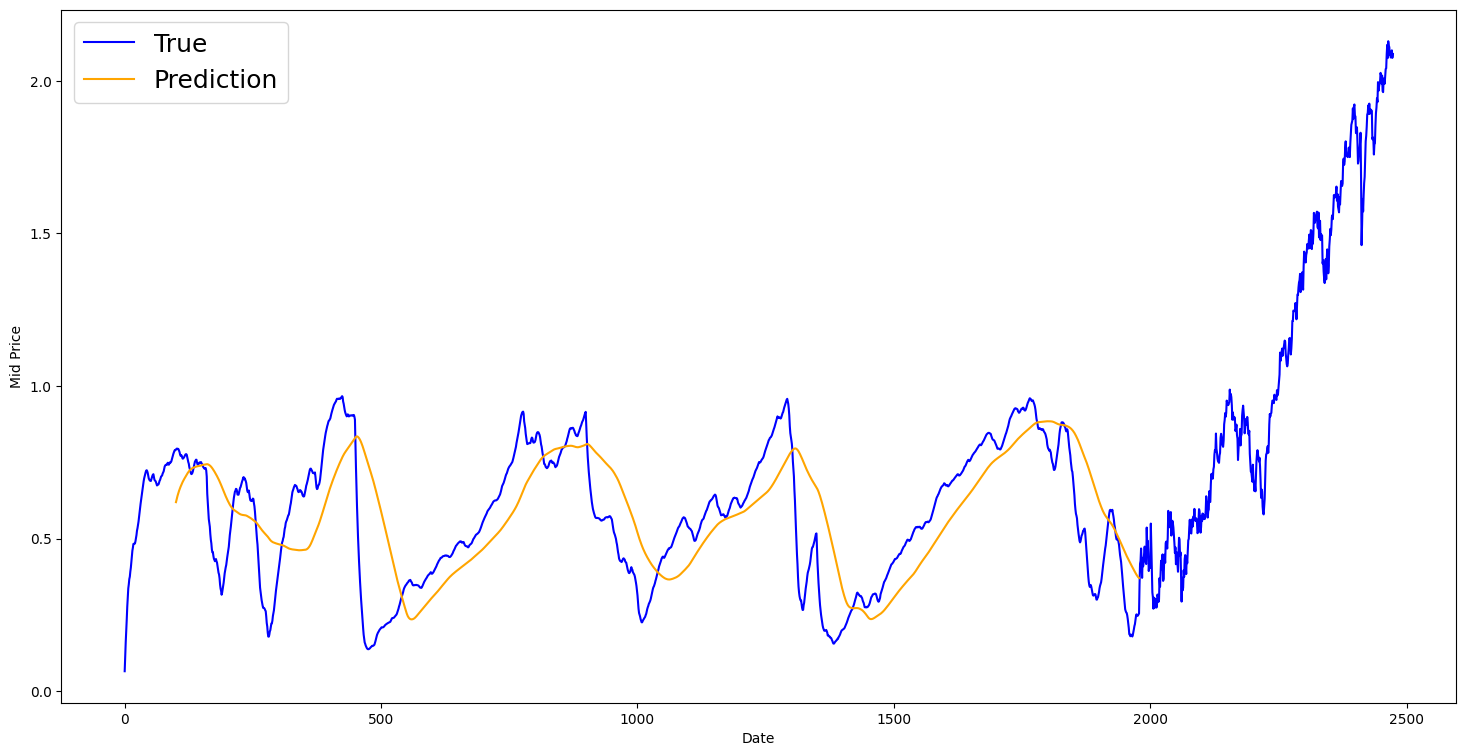

In [39]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

It seems that it is not too bad of a model for very short predictions (one day ahead). Given that stock prices don't change from 0 to 100 overnight, this behavior is sensible. Next, you will look at a fancier averaging technique known as exponential moving average.

### Exponential Moving Average

In [40]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00016


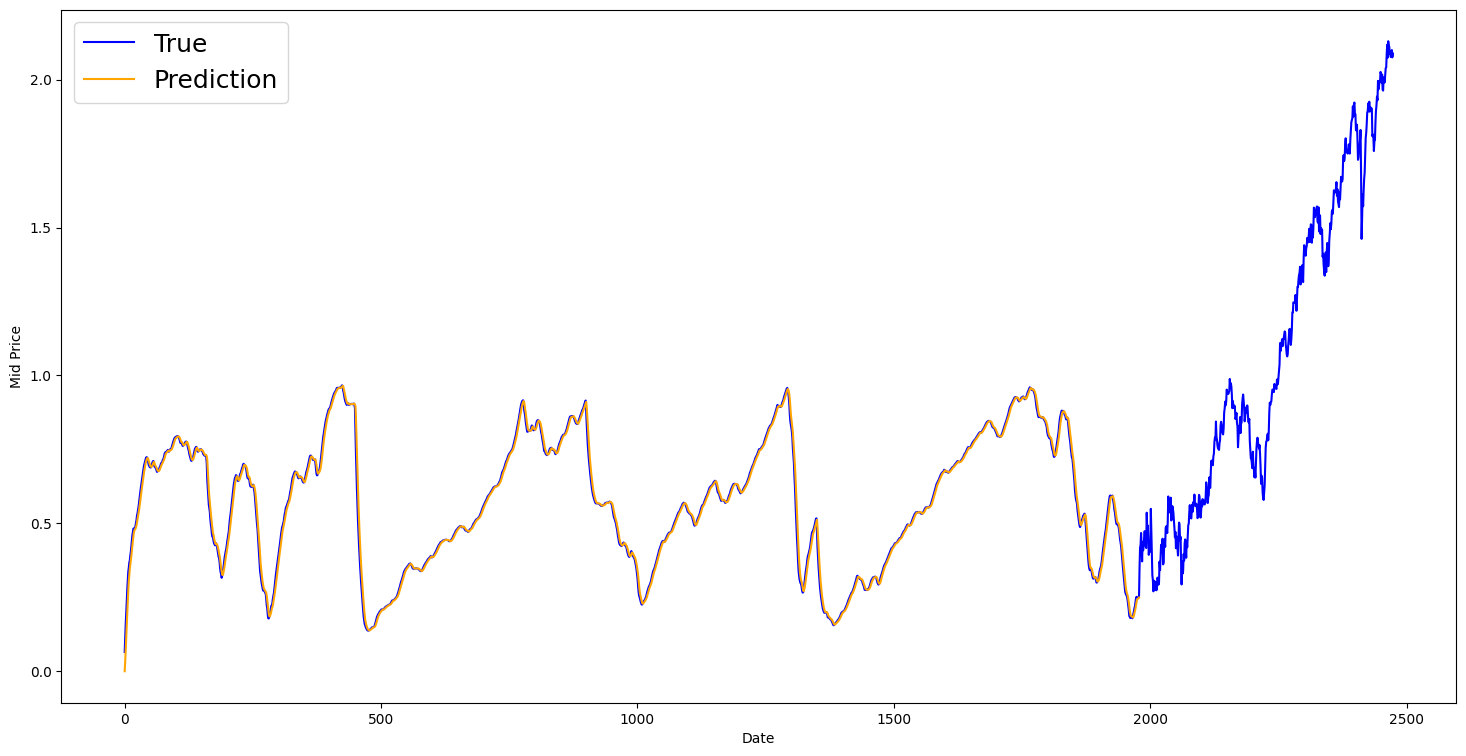

In [41]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

If Exponential Moving Average is this Good, Why do You Need Better Models?

We see that it fits a perfect line that follows the True distribution (and justified by the very low MSE). Practically speaking, we can't do much with just the stock market value of the next day. Personally what I'd like is not the exact stock market price for the next day, but would the stock market prices go up or down in the next 30 days. Try to do this, and we will expose the incapability of the EMA method.

We will now try to make predictions in windows (say you predict the next 2 days window, instead of just the next day). Then we will realize how wrong EMA can go. Here is an example:

Predict More Than One Step into the Future

MSE error for EMA averaging (30-day prediction): 0.01620


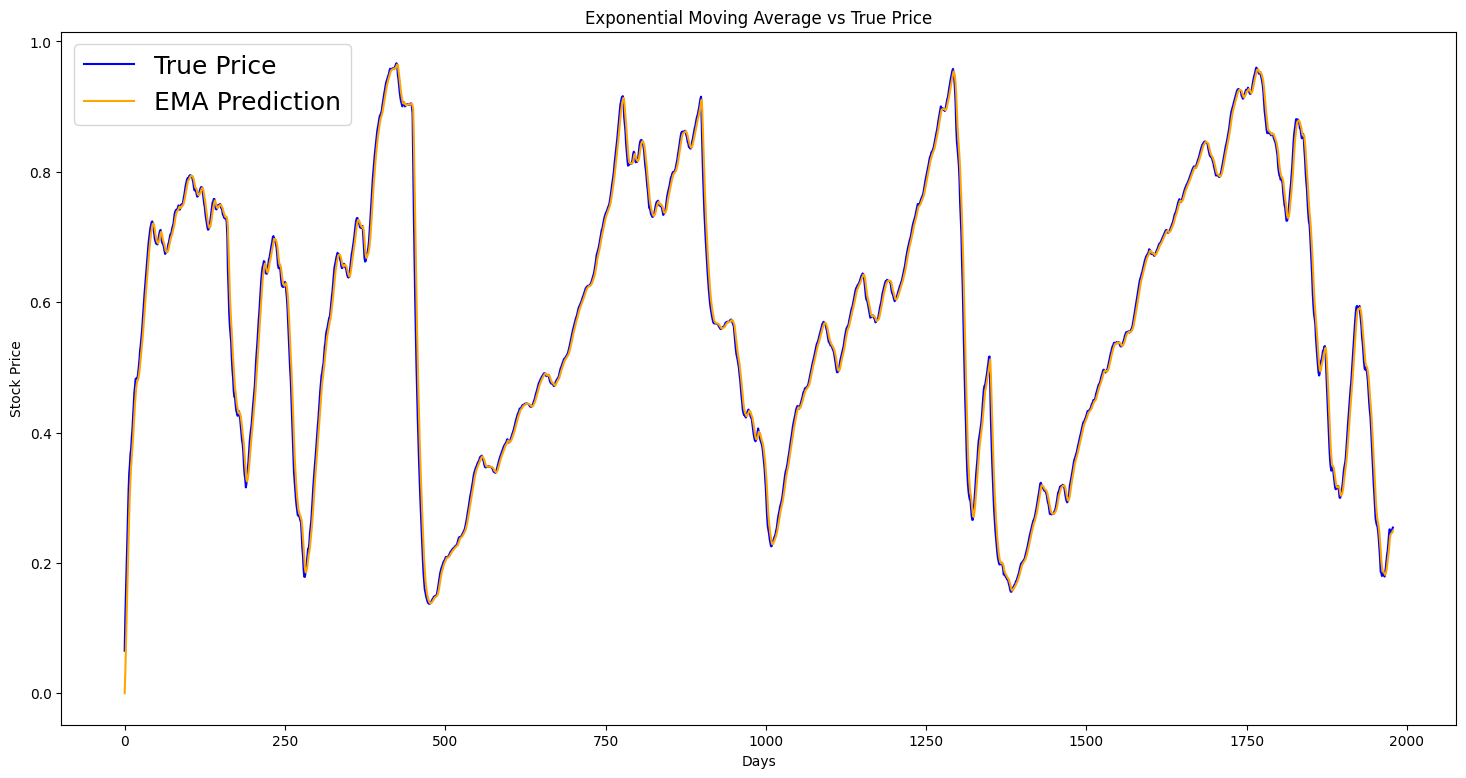

In [42]:
window_size = 100
N = len(train_data)
prediction_window = 30 # Predicting 30 days into the future

run_avg_predictions = []
mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

# Iterate over the data to calculate EMA and MSE
for pred_idx in range(1, N):
    # Calculate the running mean (EMA)
    running_mean = running_mean * decay + (1.0 - decay) * train_data[pred_idx - 1]
    run_avg_predictions.append(running_mean)
    
    # Only calculate MSE if we have enough data to look forward
    if pred_idx + prediction_window < N:
        future_price = train_data[pred_idx + prediction_window - 1]  # Price 30 days later
        mse_errors.append((running_mean - future_price) ** 2)

# Calculate the final MSE
if mse_errors:
    mse = 0.5 * np.mean(mse_errors)
    print('MSE error for EMA averaging (30-day prediction): %.5f' % mse)
else:
    print('No MSE errors to calculate.')

# Plotting the results
plt.figure(figsize=(18, 9))
plt.plot(range(N), train_data, color='b', label='True Price')
plt.plot(range(len(run_avg_predictions)), run_avg_predictions, color='orange', label='EMA Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Exponential Moving Average vs True Price')
plt.legend(fontsize=18)
plt.show()

### Step 6: Making Stock Movement Predictions Far into the Future

In [ ]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=n_input,
                                batch_size=1)
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=n_input,
                                batch_size=1)

Given the Array: 
[0.08097551 0.0735314  0.06652519 0.0642684  0.07299245 0.08104284
 0.07433982 0.07336297 0.05830638 0.06497578 0.05534225 0.06756938]
Predict this y: 
 [[0.06453787]]


In [90]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\Hp\Desktop\Kifiya\week11\GMF-PortfolioForecasting\week11\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Training the model and collecting predictions over time
predictions_over_time = []
for epoch in range(50):
    print(f'Epoch {epoch + 1}/{50}')
    model.fit(generator, epochs=1, verbose=0)
    test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)
    predictions = model.predict(test_generator)
    predictions_over_time.append(predictions)

Epoch 1/50
 36/483 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

c:\Users\Hp\Desktop\Kifiya\week11\GMF-PortfolioForecasting\week11\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Epoch 2/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 3/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 4/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 5/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 6/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 7/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 8/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 9/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 10/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 11/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 12/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 13/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 14/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Epoch 15/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 16/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 17/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 18/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 19/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 20/50
4

In [ ]:
# Evaluate the model on test data
predictions = model.predict(test_generator)
true_values = scaled_test[n_input:]

# Calculate metrics
rmse = np.sqrt(mean_squared_error(true_values, predictions))
mae = mean_absolute_error(true_values, predictions)
mape = mean_absolute_percentage_error(true_values, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 0.016522133136706342
MAE: 0.01283868327015235
MAPE: 0.014090962564615835


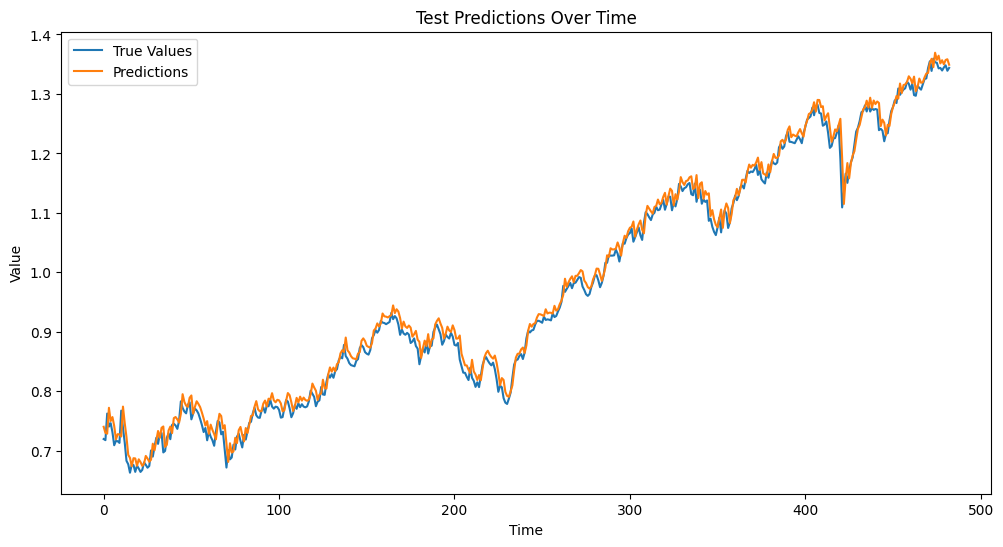

In [ ]:
# Plot the evolution of test predictions over time
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('Test Predictions Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Identify the best test prediction
best_prediction_index = np.argmin(np.abs(true_values - predictions))
best_prediction = predictions[best_prediction_index]
best_true_value = true_values[best_prediction_index]

print(f'Best Test Prediction: {best_prediction}')
print(f'Corresponding True Value: {best_true_value}')

Best Test Prediction: [1.0758964]
Corresponding True Value: [1.07599029]


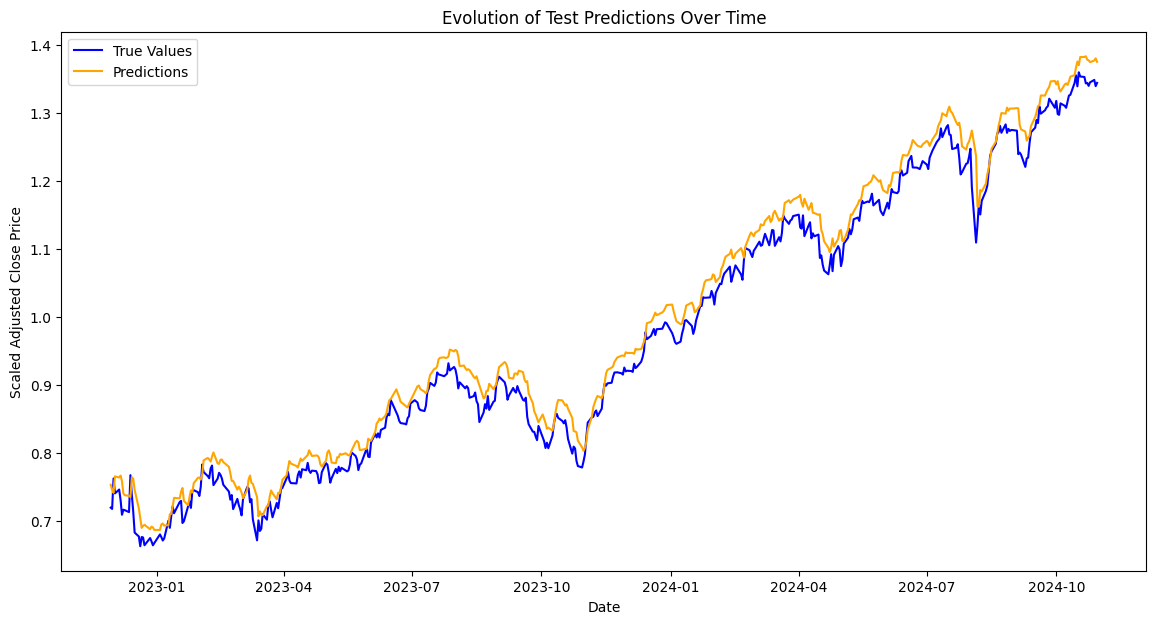

In [109]:
# Flatten the predictions and true values for plotting
predictions_flat = np.concatenate(predictions_over_time).flatten()
true_values_flat = true_values.flatten()

# Create a time index for the test data
test_dates = df.index[train_size + n_input:]

# Ensure predictions_flat matches the length of true_values_flat
predictions_flat = predictions_flat[:len(true_values_flat)]  # Adjust predictions if necessary

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_dates, true_values_flat, label='True Values', color='blue')
plt.plot(test_dates[:len(predictions_flat)], predictions_flat, label='Predictions', color='orange')  # Adjusting to match lengths
plt.title('Evolution of Test Predictions Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Adjusted Close Price')
plt.legend()
plt.show()

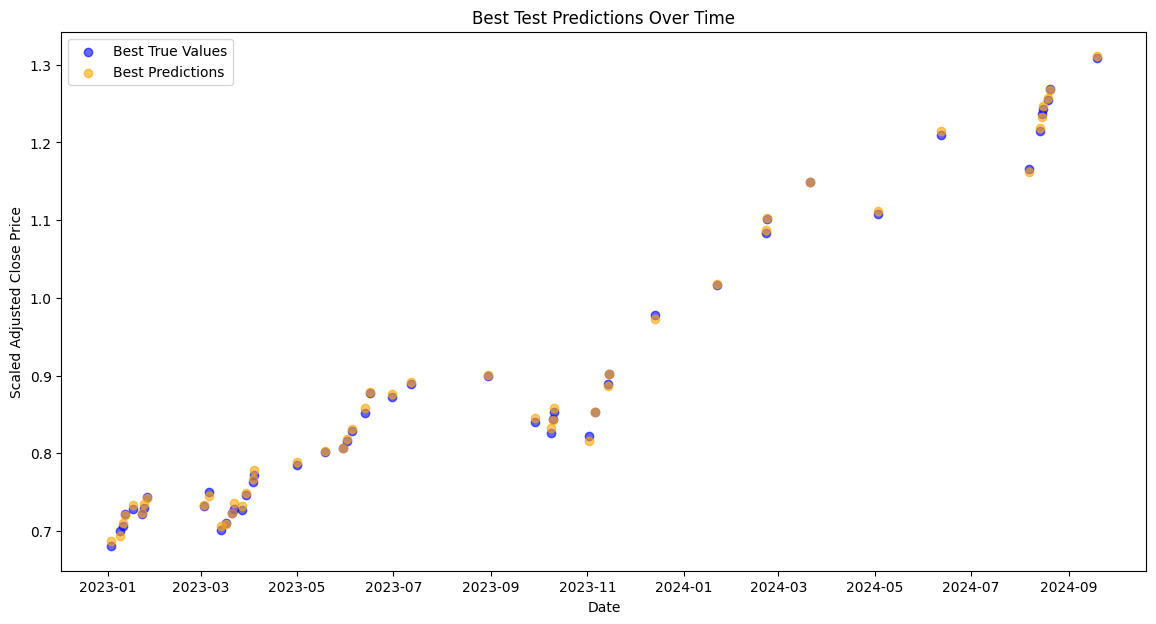

In [ ]:
# Calculate the absolute errors
errors = np.abs(true_values_flat - predictions_flat)

# Find the indices of the smallest errors
best_indices = np.argsort(errors)[:50]  # Change 50 to however many best predictions you want to visualize

# Get the corresponding dates and values
best_dates = test_dates[best_indices]
best_true_values = true_values_flat[best_indices]
best_predictions = predictions_flat[best_indices]

# Plotting
plt.figure(figsize=(14, 7))
plt.scatter(best_dates, best_true_values, label='Best True Values', color='blue', alpha=0.6)
plt.scatter(best_dates, best_predictions, label='Best Predictions', color='orange', alpha=0.6)
plt.title('Best Test Predictions Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Adjusted Close Price')
plt.legend()
plt.show()

                Actual   Predicted
Date                              
2022-11-29  396.049988  406.037476
2022-11-30  395.489990  403.789886
2022-12-01  408.769989  402.535767
2022-12-02  402.250000  409.701691
2022-12-05  403.950012  409.212708
...                ...         ...
2024-10-24  579.979980  591.124207
2024-10-25  581.510010  590.349060
2024-10-28  582.580017  591.016846
2024-10-29  579.849976  591.978577
2024-10-30  581.289978  590.453857

[483 rows x 2 columns]


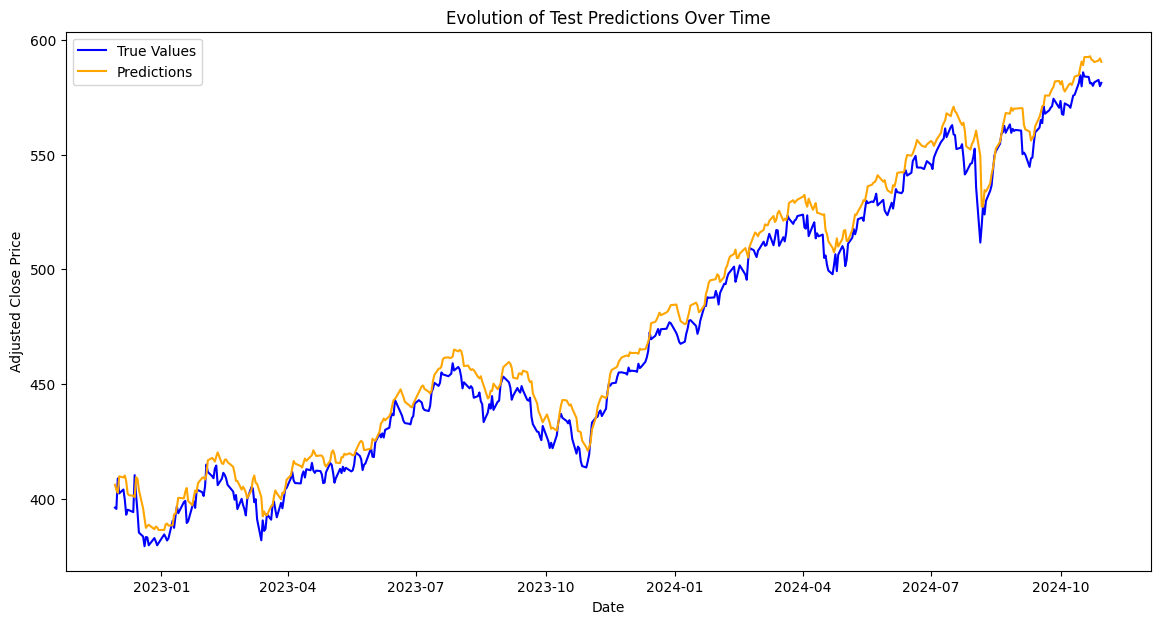

In [ ]:
# Flatten the predictions and true values for plotting
predictions_flat = np.concatenate(predictions_over_time).flatten()
true_values_flat = true_values.flatten()

# Create a time index for the test data
test_dates = df.index[train_size + n_input:]

# Reverse the scaling for predictions
predictions_scaled = predictions_flat.reshape(-1, 1)  # Reshape for the scaler
predictions_actual = scaler.inverse_transform(predictions_scaled).flatten()  # Inverse transform

# Reverse the scaling for true values if needed
true_values_scaled = true_values_flat.reshape(-1, 1)  # Reshape for the scaler
true_values_actual = scaler.inverse_transform(true_values_scaled).flatten()  # Inverse transform

# Ensure predictions_actual matches the length of true_values_actual
predictions_actual = predictions_actual[:len(true_values_actual)]  # Adjust predictions if necessary

# Create a DataFrame to display actual and predicted values
results_df = pd.DataFrame({
    'Date': test_dates[:len(predictions_actual)],  # Ensure the dates match the length of predictions
    'Actual': true_values_actual,
    'Predicted': predictions_actual
})

# Set the Date as the index
results_df.set_index('Date', inplace=True)

# Print the DataFrame
print(results_df)

# Optionally, you can also plot the data
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='True Values', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label='Predictions', color='orange')
plt.title('Evolution of Test Predictions Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')  # Change to original scale
plt.legend()
plt.show()